In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from matplotlib import pyplot as plt

import os
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms import ToPILImage
import torchvision.transforms as transforms

from num3 import Compose, ToTensor, RandomCrop, RandomRotate, RandomZoom,Resize

device: torch.device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"using device: {device}")

In [ ]:
transform1 = Compose([
    RandomCrop(.7, (26, 26)),
    RandomRotate(.5, 30),
    RandomZoom(.6, (.5, 1.5)),
    Resize((28, 28)),
    ToTensor(),
])
transform2 = Compose([
    RandomCrop(.5, (24, 24)),
    RandomRotate(.3, 15),
    RandomZoom(.4, (.7, 1.3)),
    Resize((28, 28)),
    ToTensor(),
])

train_data1 = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform1,
)

train_data2 = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=False,
    transform=transform2,
)

train_data3 = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=False,
    transform=ToTensor(),
)
    

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

class DataseteTransform(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms
        
    def __getitem__(self, index):
        img, label = self.dataset[index]
        img = ToPILImage()(img)
        if self.transforms:
            img = self.transforms(img)
            
        return img, label
    

    def __len__(self):
        return len(self.dataset)
        
train_ds1 = DataseteTransform(train_data1, transform1)
train_ds2 = DataseteTransform(train_data2, transform2)
train_ds3 = DataseteTransform(train_data3, transform2)

train_loader1 = DataLoader(train_ds1, batch_size=64, shuffle=True)
train_loader2 = DataLoader(train_ds2, batch_size=64, shuffle=True)
train_loader3 = DataLoader(train_ds3, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


class SomeCNN(nn.Module):
    def __init__(self):
        super(SomeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x= self.pool(torch.relu(self.conv1(x)))
        x= self.pool(torch.relu(self.conv2(x)))
        
        x = torch.relu(self.fc1(
            x.view(-1, 64*7*7),
        ))
        x = self.fc2(x)
        return x
        
def train_model(model ,train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_loss = []
    train_acc = []
    
    for epoch in range(num_epochs):
        running_loss = .0
        true = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            true += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = true / total
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
    return train_loss, train_acc





In [ ]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = .0
    true = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            true += (predicted == labels).sum().item()
    epoch_loss = test_loss / len(test_loader.dataset)
    epoch_acc = true / total
    
    print(f'Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}')
    
    return epoch_loss, epoch_acc

In [ ]:
model1 = SomeCNN().to(device)
model2 = SomeCNN().to(device)
model3 = SomeCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)

num_epochs = 20
train_loss1, train_acc1 = train_model(model1, train_loader1, criterion, optimizer1, num_epochs)
test_loss1, test_acc1 = test_model(model1, test_loader, criterion)
train_loss2, train_acc2 = train_model(model2, train_loader2, criterion,
                                        optimizer2, num_epochs)
test_loss2, test_acc2 = test_model(model2, test_loader, criterion)
train_loss3, train_acc3 = train_model(model3, train_loader3, criterion,
                                        optimizer3, num_epochs)
test_loss3, test_acc3 = test_model(model3, test_loader, criterion)

Epoch 1/20, Loss: 0.0172, Accuracy: 0.5943
Epoch 2/20, Loss: 0.0123, Accuracy: 0.7040
Epoch 3/20, Loss: 0.0111, Accuracy: 0.7375
Epoch 4/20, Loss: 0.0103, Accuracy: 0.7555
Epoch 5/20, Loss: 0.0098, Accuracy: 0.7689
Epoch 6/20, Loss: 0.0093, Accuracy: 0.7802
Epoch 7/20, Loss: 0.0090, Accuracy: 0.7891
Epoch 8/20, Loss: 0.0088, Accuracy: 0.7915
Epoch 9/20, Loss: 0.0084, Accuracy: 0.8005
Epoch 10/20, Loss: 0.0082, Accuracy: 0.8039
Epoch 11/20, Loss: 0.0082, Accuracy: 0.8051
Epoch 12/20, Loss: 0.0080, Accuracy: 0.8094
Epoch 13/20, Loss: 0.0080, Accuracy: 0.8097
Epoch 14/20, Loss: 0.0077, Accuracy: 0.8161
Epoch 15/20, Loss: 0.0078, Accuracy: 0.8148
Epoch 16/20, Loss: 0.0077, Accuracy: 0.8199
Epoch 17/20, Loss: 0.0076, Accuracy: 0.8214
Epoch 18/20, Loss: 0.0075, Accuracy: 0.8220
Epoch 19/20, Loss: 0.0074, Accuracy: 0.8224
Epoch 20/20, Loss: 0.0073, Accuracy: 0.8283
Test Loss: 0.2742, Test Accuracy: 0.9013
Epoch 1/20, Loss: 0.0127, Accuracy: 0.6936
Epoch 2/20, Loss: 0.0095, Accuracy: 0.7723
Ep

In [ ]:
def plot_loss_acc(loss, acc, test_loss, test_acc, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(loss)+1), loss, label='Train Loss', color='green')
    plt.plot(range(1, len(loss)+1), [test_loss]*len(loss), label='Test Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(acc)+1), acc, label='Train Accuracy', color='green')
    plt.plot(range(1, len(loss)+1), [test_acc]*len(loss), label='Test Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    

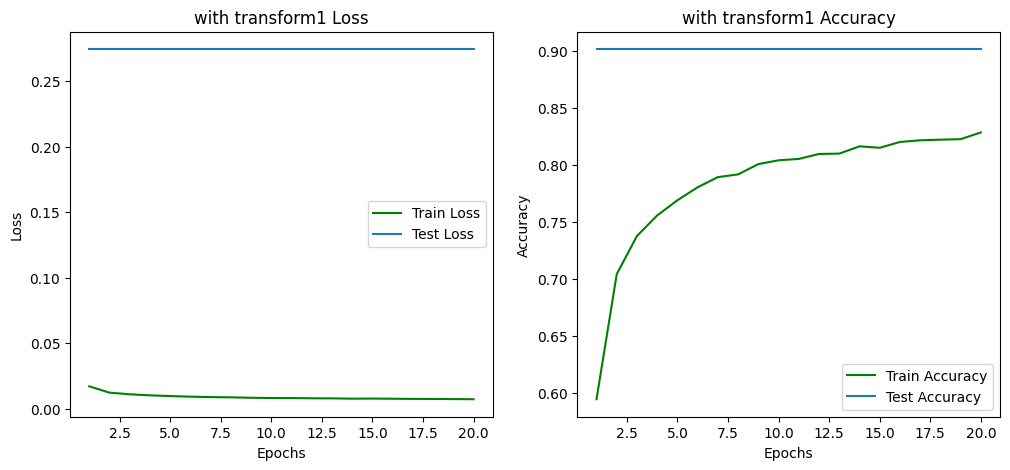

In [ ]:
plot_loss_acc(train_loss1, train_acc1, test_loss1, test_acc1, "with transform1")

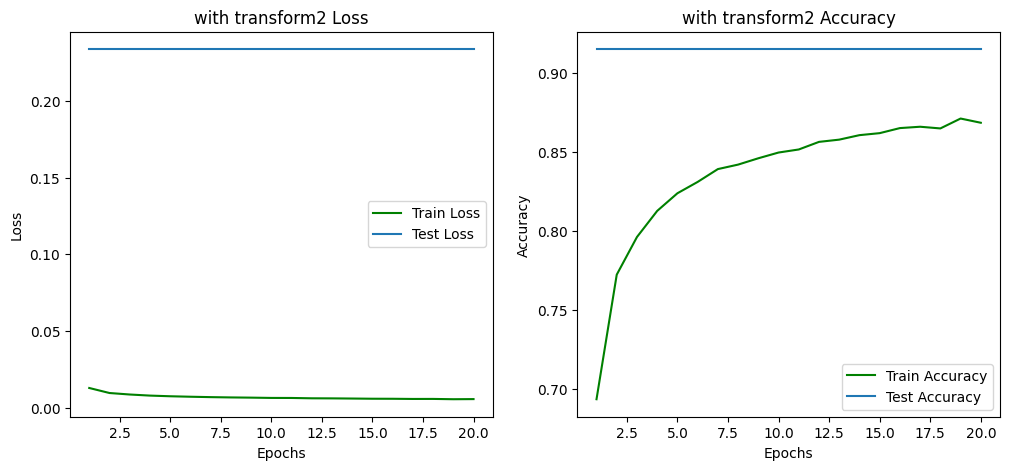

In [ ]:
plot_loss_acc(train_loss2, train_acc2, test_loss2, test_acc2, "with transform2")

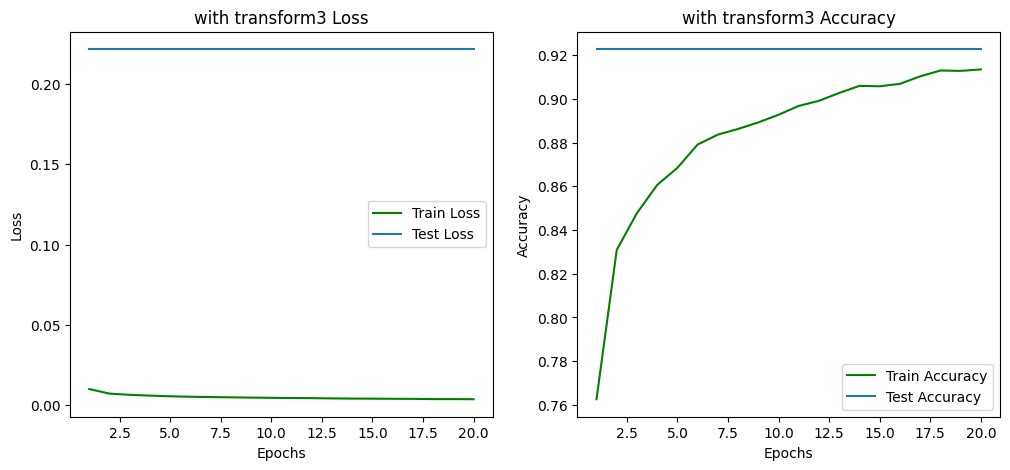

In [ ]:
plot_loss_acc(train_loss3, train_acc3, test_loss3, test_acc3, "with transform3")